## Final Project Submission

Please fill out:
* Student name: Rachel Edwards, Svitlana Glibova
* Student pace: full time
* Scheduled project review date/time: 2/12/2021, 5:00 PM PST
* Instructor name: Max Barry

## Table of Contents
[Business Problem](#Business-Problem)
1. [Import Statements](#Import-Statements)
2. [EDA](#EDA)
3. [FSM Ternary](#FSM-Ternary)
4. [Data Cleaning](#Data-Cleaning)
4. [Ternary to Binary](#Ternary-to-Binary)
5. [Binary EDA](#Binary-EDA)
6. [Folium EDA](#Folium-EDA)
7. [Models](#Models)
8. [GridSearch Tuning](#GridSearch-Tuning)
9. [Binary FSM](#Binary-FSM)
10. [Vanilla Models](#Vanilla-Models)
11. [Tuned Models](#Tuned-Models)
12. [Test Set](#Test-Set)

# Business Problem

Over 50% of Tanzania's GDP relies on livestock and agriculture while 80% of employment is directly related to those areas, institutions that need water to produce. These water pumps are used by millions all over Tanzania as you can see in the population chart. The management of these water resources is vital to the citizens of Tanzania, especially in locations that have less functioning pumps than functioning pumps. Our goal is to provide the Ministry with a way to predict whether a certain pump is functioning, while optimizing for the least amount of false negatives (predictions of a functioning pump when in fact it is not functional).These false predictions could be potentially dangerous to the citizens of Tanzania and costly for the government.  

## Data  
The data for our project has been collected and curated by [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](https://www.maji.go.tz/). It consists of 39 possible contributing factors for our predictions that include geographical data about Tanzania and its basins, who funds and manages these water pumps, how they are paid for and the populations that rely on them for safe clean water. The files and instruction on how to access them can be located in the data folder. Documentation for the data set can be found [Here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/)

### Import Statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
#import eli5
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, classification_report, log_loss
from sklearn.dummy import DummyClassifier
from sklearn import svm

from xgboost import XGBClassifier

from statsmodels.graphics.mosaicplot import mosaic

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [4]:
#df_target = pd.read_csv('../data/water_table_labels.csv')
df_target = pd.read_csv('data/tanzania_target.csv')

In [5]:
#df_train = pd.read_csv('../data/water_table_training.csv')
df_train = pd.read_csv('data/tanzania_training.csv')

# EDA

In [6]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
target_list= df_target.status_group.tolist()
df_train['target'] = target_list

In [8]:
#Correlation matrix of continuous features to check for potential multicollinearity

df_train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000


In [9]:
#Check data types of our predictor features

#df_train.dtypes
#31 objs, 8 ints

In [10]:
df_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
#Uncomment the line below to see a description of initial NaN values. We have listed the results at the bottom of this cell.

#df_train.isna().sum()



#scheme_management         3877
#scheme_name              28166
#permit                    3056
#public_meeting            3334
#subvillage                 371
#installer                 3655
#funder                    3635
#consider dropping scheme_name
#some kind of connection between funder and installer

In [12]:
df_target.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [13]:
#Group continuous features into a numeric_columns list
numeric_columns = ["amount_tsh", "gps_height", "longitude", "latitude", "num_private", "region_code", 
                   "district_code", "population", "construction_year"]

# FSM Ternary

Initally we wanted to create a ternary classification with all three possible outcomes. This is the initial ternary first simple model.

In [14]:
dummy_model = DummyClassifier(strategy="most_frequent")
#dummy model that will pick the largest class

In [15]:
numeric_df = df_train[numeric_columns]
X = numeric_df.drop("num_private", axis=1)
y = df_target["status_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)
#just using numeric columns as features

In [16]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [17]:
dummy_model.predict(X_train)

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype='<U10')

In [18]:
cross_val_score(dummy_model, X_train, y_train, cv=3)
#initial accuracy score of about 54% 

array([0.54255892, 0.54249158, 0.54249158])

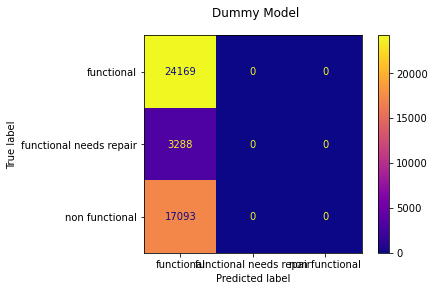

In [19]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

Due to the nature of the FSM, accuracy was incredibly low but recall and precision were actually 0% due to predicting only 'functional.'

# Data Cleaning

We chose to drop these particular columns because ther was a lot of crossover information between them. Some were dropped because they had too many unique values such that when one hot encoding would create a dataset with too many unique signals.

In [20]:
to_drop = ['date_recorded',  
'installer',
'wpt_name',  
'subvillage',  
'recorded_by',  
'scheme_name',  
'extraction_type_group',  
'payment',  
'water_quality',  
'quantity',  
'source_type',  
'waterpoint_type_group',
'num_private',
'region',
'ward',
'id',
'public_meeting'           
]
df_clean = df_train.drop(to_drop, axis = 1)
#drop columns we will not be using

In [21]:
pd.set_option('display.max_columns', None)
df_clean.head(5)

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,0.0,Action In A,0,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,0,NaN,True,0,gravity,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [22]:
df_clean.shape
#(59400, 24)
#amount_tsh, gps_height, longitude, latitude, population

(59400, 24)

In [23]:
col_names = df_clean.columns
cat = [ 'funder', 'basin',
       'region_code', 'district_code', 'lga',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type']

In [24]:
df_clean.dropna(inplace=True)
#get rid of NaN rows

In [25]:
df_clean.shape
#(51329, 24)

(51329, 24)

In [26]:
#The data has been reduced to 51,239 rows with no missing values. Uncomment the line below to see all columns used and
# their respective NaN values.

df_clean.isna().sum()

amount_tsh               0
funder                   0
gps_height               0
longitude                0
latitude                 0
basin                    0
region_code              0
district_code            0
lga                      0
population               0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source                   0
source_class             0
waterpoint_type          0
target                   0
dtype: int64

# Ternary to Binary

Due to having such a large class imblance we chose to change our class types form three to two, we grouped 'non funcitonal needs repair' into 'non funcitonal' for a more even class split. This is also due to our goal being to predict pumps that need repair, whether functional or not.

In [27]:
df_clean.target.value_counts()
#functional                 32259
#non functional             22824
#functional needs repair     4317-

#Check types nad counts of target

functional                 28076
non functional             19626
functional needs repair     3627
Name: target, dtype: int64

In [28]:
df_clean.head()

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional


In [29]:
target_list = df_clean.target.tolist()

In [30]:
t_list = ['non functional' if i=='functional needs repair' else i for i in target_list]
#convert all functional needs repair tags to simply non functional to create a binary target

In [31]:
df_clean['bi_target'] = t_list

In [32]:
df_clean.head()

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target,bi_target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional,functional


In [33]:
df_clean = df_clean.drop(['target'], axis = 1)

In [34]:
df_combo = df_clean[['region_code', 'scheme_management', 'quality_group', 
                    'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type', 'bi_target']]
df_num = df_clean[['amount_tsh', 'construction_year', 'latitude', 'longitude']]
df_completed = df_num.join(df_combo, how='outer')
df_completed.shape
#(51329, 12)

(51329, 12)

# Binary EDA

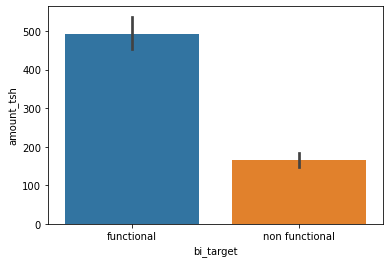

In [35]:
sns.barplot(data=df_clean, x="bi_target", y="amount_tsh");
#correlation between functional pumps and the amount of total static head
#the higher the TSH the moe likely a pump is to be functional

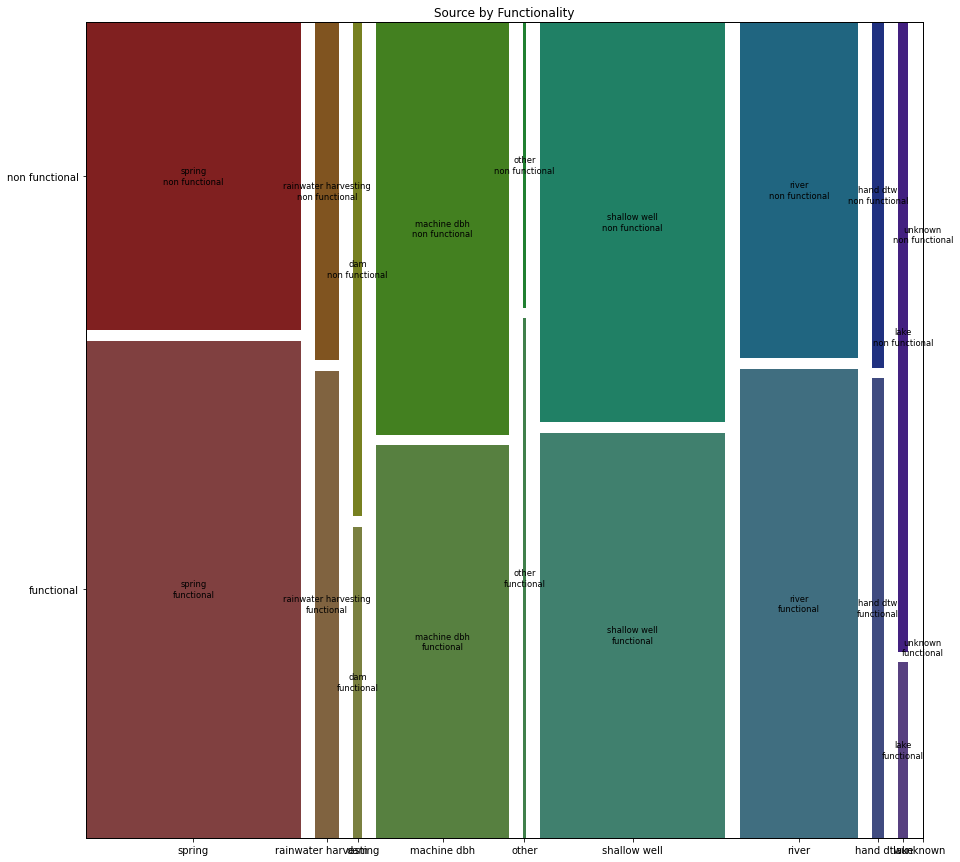

In [36]:
fig, ax = plt.subplots(figsize = (15,15))
mosaic(df_clean, ['source', 'bi_target'], gap = 0.02, ax =ax, title='Source by Functionality')
plt.show;
#mosaic plot of categorical data between source and funcctionality
#spring and river appear to have a positive correlation with functional

In [37]:
df_clean.head()
df_basin_pop = df_clean[['basin', 'population', 'bi_target']]
#subset for just columns being used

In [47]:
df_pop_map = df_basin_pop.groupby(['basin']).sum()
pop = df_pop_map.sort_values('population')
#groupby to check the total population associated with each basin
type(pop)

pandas.core.frame.DataFrame

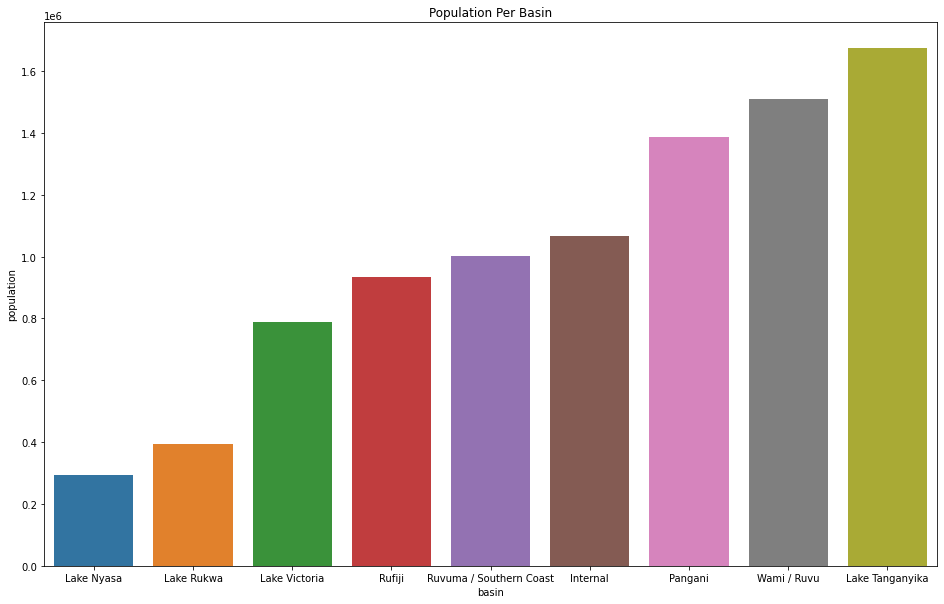

In [49]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=pop.index, y=pop.population, data=df_pop_map, ax =ax).set_title('Population Per Basin');
#plot of each basin and its population

In [38]:
df_basin_target = df_basin_pop.drop('population', axis = 1)
#drop population from data fram

In [39]:
df_basin_target_map = df_basin_target.value_counts()
#check value_counts() for how many functional or non funcitonal water points each basin has
#df_basin_target.groupby([ 'basin']).sum()
df_basin_target_map

basin_name = ['Pangani', 'Lake Victoria', 'Lake Victoria', 'Rufiji', 'Internal', 'Pangani', 'Wami / Ruvu', 'Lake Tanganyika',
              'Wami / Ruvu', 'Lake Tanganyika', 'Internal', 'Lake Nyasa', 'Ruvuma / Southern Coast',
              'Rufiji', 'Ruvuma / Southern Coast', 'Lake Rukwa', 'Lake Nyasa', 'Lake Rukwa']

target_list = ['functional', 'non functional', 'functional', 'functional', 'functional', 'non functional', 'functional'
               , 'non functional', 'non functional', 'functional', 'non functional', 'functional', 'non functional', 
               'non functional', 'functional', 'non functional', 'non functional', 'functional']

count_list = [5160, 4280, 4211, 4033, 3802, 3400, 3116, 3058, 2815, 2792, 2528, 2480, 2462, 2005, 1487, 1440, 1265, 995]

dict = {'basin':basin_name, 'target': target_list, 'count': count_list}
df_b_t_c = pd.DataFrame(dict)
#use information from .value counts to constuct a new dataframe containing
#the number of funcitonal or non functional water points for each basin

We wanted to highlight the importance of this data set by visualising areas that had more non functional water pumps than functional. Several of these regions are home to over ten million people but have less funcitoning water pumps than non funcitoning water pumps.

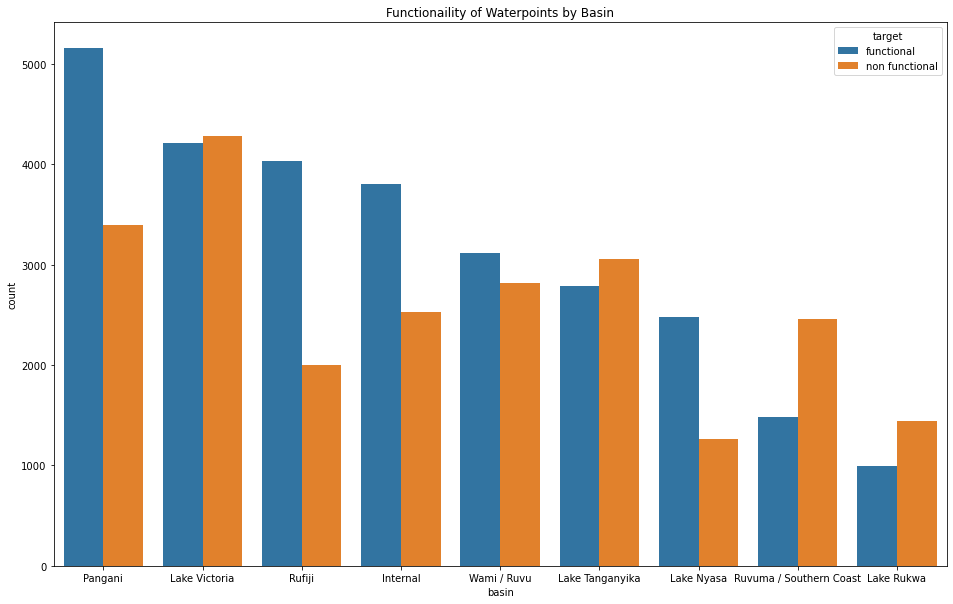

In [40]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="basin", y="count", hue="target", data=df_b_t_c, ax = ax).set_title('Functionaility of Waterpoints by Basin');
#plot of how many funcitonal and non functional water points each absin has

# Folium EDA

We mapped each region to describe the locations of functional versus non functional pumps.

In [41]:
df_clean.basin.value_counts()
#cheack how many water points each basin has

Pangani                    8560
Lake Victoria              8491
Internal                   6330
Rufiji                     6038
Wami / Ruvu                5931
Lake Tanganyika            5850
Ruvuma / Southern Coast    3949
Lake Nyasa                 3745
Lake Rukwa                 2435
Name: basin, dtype: int64

In [42]:
df_clean.bi_target.value_counts()
#check target distribution

functional        28076
non functional    23253
Name: bi_target, dtype: int64

In [43]:
def namer(name):
    """takes in a name as a string and returns folium formatted name"""
    named = "<i>" + name +"</i>"
    return named

In [44]:
def basin_mapper():
    
    """Takes no argument and plots all 8 basins on folium map"""
    
    b_map = folium.Map(location=[-6.1630, 35.7516], zoom_start=6, tiles="Stamen Terrain")
    #plots initial space for general area, using tanzania's coordinates
    
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
              'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    for i in range(0, len(basins)):
        folium.Marker(long_lat[i], namer(basins[i]), icon=folium.Icon(color="purple"), tooltip=tooltip).add_to(b_map)
        #plots a purple marker for each basin
    
    return b_map

In [45]:
def basin_split(bname, df):
    """takes the name of a basin as a string and the cleaned df. 
    Returns pair as a list iwth basin name and basin coords.
    Returns coords_target as a nested list of waterpoint coords and their functionality tag
    """
    tooltip = "Click me!"
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    for name in range(0, len(basins)):
        if basins[name] == bname:
            pair = [bname, long_lat[name]]
            #gets the coordinates for the specifed basin only
    
    basin_df = df[['latitude', 'longitude', 'basin', 'bi_target']]

    df_basin = basin_df.loc[basin_df['basin'] == bname]
    
    target = df_basin.bi_target.head(200).tolist()
    long = df_basin.longitude.head(200).tolist()
    lat = df_basin.latitude.head(200).tolist()
    
    coords = [[la,lo] for la,lo in zip(lat, long)]
    #list comp to create lists of water point coordinates, [latitude, longitude]
    coords_target = [[t,c] for t,c in zip(target, coords)]
    #nested list containing [functionality, [latitude, longitude]]
    
    #print(coords[:5])

    return pair, coords_target

In [46]:
def map_build(basin):
    """takes in one parameter that consists of a list with a basin name and its coordinates
    and the coordinates of every water point connected to that basin. Creates a map with a
    marker for the basin and marlers for x amount water points. Builds maps ofindividual basins."""
    
    basin_name = basin[0][0]
    basin_coords = basin[0][1]
    coords = basin[1]
    
    b = folium.Map(location= basin_coords, zoom_start=8, tiles="Stamen Terrain")
    #plots initial space for general area, using specified basin's coordinates
    
    tooltip = "Click me!"
    
    for coord in coords:
        if coord[0] == 'functional':
            folium.Marker(coord[1], "<i>str(i)</i>", icon=folium.Icon(color="green"), tooltip=tooltip).add_to(b)
        else:
            folium.Marker(coord[1], "<i>str(i)</i>", icon=folium.Icon(color="red"), tooltip=tooltip).add_to(b)
            #plots green markers for functional basin and red markers for non functional basins
    
    folium.Marker(basin_coords, namer(basin_name), tooltip=tooltip, icon=folium.Icon(color="purple")).add_to(b)
    #plots purple ,markers for specified basin
        
    return b

Use the code below to map the individual regions to see a small distriubiotn of funcitonal versus non funcitonal wells in each basin

In [47]:
basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
# to use functioon map_build, a basin name must be picked and passed
#the return value should be saved in a variable and that variable
#must be run in its own cell

In [48]:
bname = basins[0]
Pangani  = map_build(basin_split(bname, df_clean))

In [49]:
Pangani 

In [50]:
bname_list = bname = basins[1]
Lake_Victoria  = map_build(basin_split(bname, df_clean))

In [58]:
bname_list = bname = basins[2]
Lake_Nyasa  = map_build(basin_split(bname, df_clean))

In [59]:
bname_list = bname = basins[3]
Lake_Rukwa = map_build(basin_split(bname, df_clean))

In [60]:
bname_list = bname = basins[4]
Lake_Tanganyika = map_build(basin_split(bname, df_clean))

In [61]:
bname_list = bname = basins[5]
Rufigi = map_build(basin_split(bname, df_clean))

In [62]:
bname_list = bname = basins[6]
wami_ruvu  = map_build(basin_split(bname, df_clean))

In [63]:
bname_list = bname = basins[7]
Ruvuma  = map_build(basin_split(bname, df_clean))

In [64]:
def Full_map(df):
    """Takes in the cleaned data frame and plots all eight basins and however many water points are specified"""
    
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    b = folium.Map(location= [-6.1630, 35.7516], zoom_start=6, tiles="Stamen Terrain")
    #plots initial space for general area, using tanzania's coordinates
    
    tooltip = "Click me!"
    
    for i in range(0, len(basins)):
        folium.Marker(long_lat[i], namer(basins[i]), tooltip=tooltip, icon=folium.Icon(color="purple")).add_to(b)
        #plots all 8 basins as purple markers

        
    basin_df = df[['latitude', 'longitude', 'basin', 'bi_target']]
    
    for index, row in basin_df.head(400).iterrows():
        if row['bi_target'] =='functional':
            folium.Marker([row['latitude'],row['longitude']], "<i>str(i)</i>", icon=folium.Icon(color="green"), tooltip=tooltip).add_to(b)
        else:
            folium.Marker([row['latitude'],row['longitude']], "<i>str(i)</i>", icon=folium.Icon(color="red"), tooltip=tooltip).add_to(b)
            #plots green markers for functional basin and red markers for non functional basins
        
    return b

In [69]:
Full_map(df_clean)
#prints out the entire map of Tanzania with all basins and 800 pumps

# Models

## Iterative Model Building from First Simple Model on Binary Data

From here, we chose to encode the target as following:  
0 indicates all 'functional' water pumps  
1 indicates all 'non functional' or 'functional needs repairs' water pumps - these were both converted to 'non functional' in an earlier part of the notebook. 

In [51]:
##all predictor features
final_columns_list = ['amount_tsh', 'longitude', 'latitude', 'construction_year', 'region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

#separating features by continuous and categorical values
numericals = ['amount_tsh', 'longitude', 'latitude', 'construction_year']
categoricals = ['region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

#encoding target as 0 or 1
conditions = [df_clean['bi_target'] == 'functional', df_clean['bi_target'] == 'non functional']
choices = [0, 1]

df_clean['status_no'] = np.select(conditions, choices)
df_clean.drop('bi_target', axis = 1, inplace = True)

In [52]:
#Train test split
X = df_clean[final_columns_list]
y = df_clean['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

### Transformation on the Train Set

In [53]:
from src.transformers import CustomTransformer

We built pipelines to transform and fit this data to vanilla models for iterative model building.

In [54]:
logreg_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('logreg', LogisticRegression())])
bernoulli_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('bern', BernoulliNB())])
knn_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
tree_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('tree', DecisionTreeClassifier())])
forest_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('forest', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('xgb', XGBClassifier())])


In [89]:
logreg_pipe.named_steps['transform']

TypeError: 'CustomTransformer' object is not subscriptable

In [90]:
onehot_columns = list(tree_pipe.named_steps['transform'].named_transformers_['ohe'].named_steps['ohe'].get_feature_names(input_features=categorical_features))
numeric_features_list = numericals
numeric_features_list.extend(onehot_columns)

AttributeError: 'CustomTransformer' object has no attribute 'named_transformers_'

## GridSearchCV Tuning

### Hyperparameter Options for Models

We then created parameter grids to perform searches on these models to establish ideal starting parameters for hyperparameter tuning. These will be used after creating vanilla to determine best baseline performance.

In [55]:
##Logistic Regression Hyperparameters
logreg_params = {
   'logreg__C':[.1, .75],
   'logreg__max_iter':[500],
   'logreg__solver':['lbfgs', 'liblinear']
            }

##Bernoulli Naive Bayes Hyperparameters
bernoulli_params = {'bern__alpha': list(np.linspace(.1, 1, 10))}

##K Nearest Neighbors
knn_params = {
    'knn__n_neighbors': [3, 7, 12], 
    'knn__weights':['uniform', 'distance'], 
    'knn__p':[1, 2, 3, 4]
             }

##Decision Tree
tree_params = {
    'tree__criterion':['gini', 'entropy'],  
    'tree__max_depth': [10, 25, 40, 55],
    'tree__min_samples_leaf':[1, 2, 3], 
    'tree__max_features': ['auto', 'sqrt']
              } 

##Random Forest
forest_params = {
    'forest__n_estimators':[100, 125],
    'forest__criterion':['gini', 'entropy'],
    'forest__max_depth':[20, 40, None],
    'forest__min_samples_leaf':[1, 2, 3], 
    'forest__max_features': ['auto','sqrt', 'log2']
                }

##XGBoost
xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [6, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 120]
            }

## GridSearchCV  
### Logistic Regression

In [79]:
log_grid = GridSearchCV(estimator = logreg_pipe, param_grid = logreg_params, scoring = 'recall')
log_grid.fit(X_train, y_train)
log_grid.best_params_

{'logreg__C': 0.75, 'logreg__max_iter': 500, 'logreg__solver': 'lbfgs'}

### Bernoulli

In [ ]:
bern_grid = GridSearchCV(estimator = bernoulli_pipe, param_grid = bernoulli_params, scoring = 'recall')
bern_grid.fit(X_train, y_train)
bern_grid.best_params_

### Decision Tree 

In [2]:
tree_grid = GridSearchCV(estimator = tree_pipe, param_grid = tree_params, scoring = 'recall')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

NameError: name 'GridSearchCV' is not defined

We did have to make the switch to using RandomSearchCV for a less exhaustive search than GridSearch due to the time cost of perfoming a gridsearch on heavier and ensemble models.

### RandomSearchCV on K Nearest Neighbors
Due to computational weight, this code has been commented out in order to run the notebook with less time interference, as some of these searches do take a significant amount. The code is fully functional, however.

In [ ]:
#rs_knn = RandomizedSearchCV(estimator = knn_pipe,
#                        param_distributions = knn_params,
#                        n_iter = 10,                      
#                        random_state=42)

#rs_knn.fit(X_train, y_train)
#rs_knn.best_params_

### RandomSearchCV on Random Forest

In [ ]:
rs_forest = RandomizedSearchCV(estimator = forest_pipe,
                        param_distributions = forest_params,
                        n_iter = 10,                      
                        random_state=42)

rs_forest.fit(X_train, y_train)
rs_forest.best_params_

### RandomSearchCV on XGB
Still rather time consuming but does work.

In [71]:
rs = RandomizedSearchCV(estimator = xgb_pipe,
                        param_distributions = xgb_params,
                        n_iter = 10,                      
                        random_state=42, return_train_score = True)

rs.fit(X_train, y_train)
rs.best_params_, rs.best_score_, rs.__dict__

C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:25:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:25:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:25:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:25:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:26:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:27:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\utils\metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\lib\site-packages\sklearn\pipeline.py", line 618, in score
    Xt = transform.transform(Xt)
  File "C:\Users\edwardsrk\anaconda3\envs\wtpts_env\

[15:28:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

# Binary FSM

We chose to build an initial model using the mode of the target data as proof of concept and to establish a baseline score for which to improve upon.

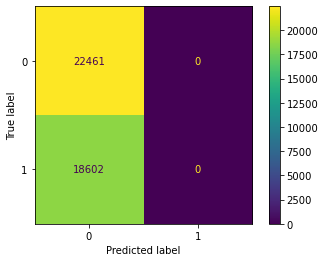

In [56]:
dummy_model = DummyClassifier(strategy = 'most_frequent')
dummy_model.fit(X_train, y_train)

plot_confusion_matrix(dummy_model, X_train, y_train);

In [57]:
print("Accuracy Scores:", cross_val_score(dummy_model, X_train, y_train))
print("Mean Accuracy:", cross_val_score(dummy_model, X_train, y_train).mean())
"Recall Scores:", cross_validate(dummy_model, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.54705954 0.54693778 0.54693778 0.54700438 0.54700438]
Mean Accuracy: 0.5469887741085512


('Recall Scores:',
 {'fit_time': array([0.00598311, 0.00494623, 0.00501561, 0.00498509, 0.00498629]),
  'score_time': array([0.00295162, 0.00199485, 0.00301719, 0.00299311, 0.00299144]),
  'test_score': array([0., 0., 0., 0., 0.]),
  'train_score': array([0., 0., 0., 0., 0.])})

Model accuracy was approximately 55% but due to the nature of the dummy model, both recall and precision were 0%. Our main goal is to maximize recall but the accuracy is likely to increase alongside it because the starting point is close to random.

# Vanilla Models

These "vanilla" models have no hyperparameter tuning - they were used to determine which models were the most successful out of the gate. Since our goal was to maximize recall and overall model performance, we selected less interpretable options such as XGBoost.

Our motivation was to maximize recall (minimize false negatives) due to the potential cost of predicting that a water source does not need repair when it actually does.

## Model 1 - Logistic Regression

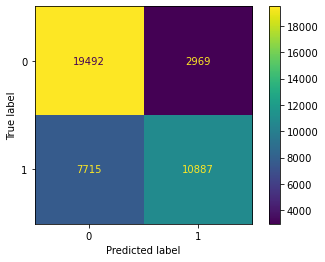

In [72]:
logreg_pipe.fit(X_train, y_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [ ]:
print("Accuracy Scores:", cross_val_score(logreg_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(logreg_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(logreg_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

## Model 2 - K Nearest Neighbors

In [ ]:
knn_pipe.fit(X_train, y_train)
plot_confusion_matrix(knn_pipe, X_train, y_train);

In [ ]:
#print("Accuracy Scores:", cross_val_score(knn_pipe, X_train, y_train))
#"Recall Scores:", cross_validate(knn_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')
#do not uncomment unless you're comfortable with waiting a really long time

## Model 3 - Decision Tree Classifier

In [ ]:
tree_pipe.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe, X_train, y_train);

In [ ]:
print("Accuracy Scores:", cross_val_score(tree_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

## Model 4 - XGB Classifier

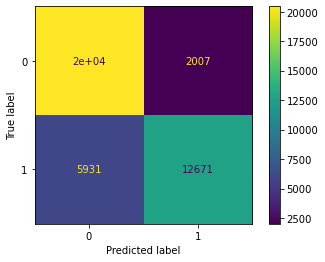

In [63]:
xgb_pipe.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe, X_train, y_train);

In [64]:
print("Accuracy Scores:", cross_val_score(xgb_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78144405 0.79763789 0.7850968  0.78190453 0.78531417]
Mean Accuracy: 0.7862794890710905


('Recall Scores:',
 {'fit_time': array([4.28215957, 4.22891355, 4.10272384, 4.11511326, 4.22149563]),
  'score_time': array([0.16262031, 0.14587808, 0.14113045, 0.14876771, 0.15089273]),
  'test_score': array([0.65456989, 0.6855684 , 0.6640688 , 0.65806452, 0.65349462]),
  'train_score': array([0.68841554, 0.68973859, 0.6886634 , 0.69231286, 0.68062088])})

## Model 5 - Random Forest Classifier

In [ ]:
forest_pipe.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe, X_train, y_train);

In [ ]:
print("Accuracy Scores:", cross_val_score(forest_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Models 3, 4, and 5 were the most successful so below, we will be iterating on their hyperparameters.

# Tuned Models

## Tuned Model 1 - Decision Tree

In [80]:
tree_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                   ('tree', DecisionTreeClassifier(criterion = 'entropy',
                                                                   max_depth = 30,
                                                                   max_features = 'sqrt'))])

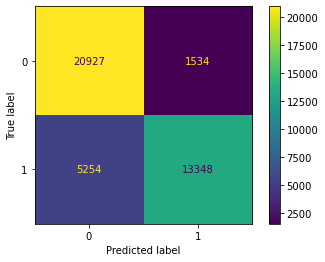

In [81]:
tree_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe_tuned, X_train, y_train);

In [82]:
print("Accuracy Scores:", cross_val_score(tree_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.77231219 0.7798612  0.77389504 0.77216269 0.76960546]
Mean Accuracy: 0.7760026383510774


('Recall Scores:',
 {'fit_time': array([0.30303288, 0.27500415, 0.31313181, 0.30099964, 0.3060267 ]),
  'score_time': array([0.03599453, 0.04499125, 0.03699923, 0.04300618, 0.03700089]),
  'test_score': array([0.63145161, 0.67320613, 0.66326256, 0.63360215, 0.65456989]),
  'train_score': array([0.70387045, 0.73039446, 0.73106646, 0.69553823, 0.7287327 ])})

## Tuned Model 2 - XGBoost Classifier

The three complex models were relatively close in maximizing recall.  
However, the XGBoost model was the most responsive with regard to hyperparameter tuning. In the commented code, we included several of the hyperparameter combinations that were iterated upon. We began with the best parameters as detailed by the RandomSearch performed earlier in this notebook.  

Trial and error tuning of parameters beginning at Search results led to the following being the most successful:

In [58]:
xgb_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                  ('xgb', XGBClassifier(subsample=0.9,
                                                        reg_lambda=.1,
                                                        n_estimators=500,
                                                        booster = 'dart',
                                                        min_child_weight=1.0,
                                                        max_depth=40,
                                                        learning_rate=0.3,
                                                        gamma=.8,
                                                        eta=0.9,
                                                        colsample_bytree=0.9,
                                                        colsample_bylevel=0.5))])

#nestimators = 400, lr = .2, depth = 40, reg_lambda=1.0, 20589, 1872, 4568, 14034
#nestimators = 500, lr = .4, depth = 40, reg_lambda=1.0, 20558, 1903, 4496, 14106
#nestimators = 600, lr = .3, depth = 40, reg_lambda=1.0, 20608, 1853, 4534, 14068
#nestimators = 600, lr = .3, depth = 4,  reg_lambda=1.0, 2e+04, 2117, 5684, 12918
#nestimators = 500, lr = .3, depth = 10, reg_lambda=1.0, 20504, 1957, 4792, 13810
#nestimators = 500, lr = .3, depth = 40, reg_lambda=0.5, 20599, 1862, 4496, 14106
#nestimators = 500, lr = .3, depth = 10, reg_lambda=0.2, 20644, 1817, 4513, 14089


#nestimators = 500, lr = .3, depth = 40, reg_lambda=0.1, gamma=0.2, 20600, 1861, 4451, 14151

#estimators = 500, depth = 40, lr = .3, lambda = .1, gamma = .8 20612 1849 4469 14133
#estimators = 500 depth = 40, lr = .3, lambda = .1, gamma = .8, booster = 'dart' 20577 1884 4434 14168

In [ ]:
xgb_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);

The recall calculations below take a little while, but they do work.  

In [75]:
print("Accuracy Scores:", cross_val_score(xgb_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')


KeyboardInterrupt



Example result:

Accuracy Scores: [0.78667965 0.79374163 0.78570559 0.78592304 0.78677545]  
Mean Accuracy: 0.7877650724093515  
('Recall Scores:',  
 {'fit_time': array([21.27556515, 20.48738503, 20.44357967, 19.84486055, 19.39542603]),  
  'score_time': array([0.21004176, 0.20481229, 0.1889286 , 0.17752552, 0.20445323]),  
  'test_score': array([0.67903226, 0.70357431, 0.68691212, 0.68494624, 0.6983871 ]),  
  'train_score': array([0.74828652, 0.749412  , 0.74826961, 0.7485553 , 0.75251982])})  

## Tuned Model 3 - Random Forest Classifier

Although the search suggested that using gini as a criterion may be a stronger choice, the model seemed to perform better using entropy and with a set maximum depth.

In [62]:
forest_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),
                                     ('forest', RandomForestClassifier(n_estimators=200,
                                                                       max_features='sqrt',
                                                                       max_depth=45,
                                                                       criterion='entropy'))])

In [ ]:
forest_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe_tuned, X_train, y_train);

In [ ]:
print("Accuracy Scores:", cross_val_score(forest_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

# Test Set Predictions and Data Explanation

### XGBoost Classifier predictions on the train and test sets for further data explanation

In [60]:
xgb_pipe_tuned.fit(X_train, y_train)

#Test and Train Predictions
xgb_train_preds = xgb_pipe_tuned.predict(X_train)
xgb_test_preds = xgb_pipe_tuned.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_test_preds)
xgb_precision = precision_score(y_test, xgb_test_preds)
xgb_recall = recall_score(y_test, xgb_test_preds)

xgb_y_probas = xgb_pipe_tuned.predict_proba(X_test)[:,1]
xgb_tpr, xgb_fpr, xgb_thresholds = roc_curve(y_test, xgb_y_probas)
xgb_auc = auc(xgb_tpr, xgb_fpr)


print("XGBoost Classifier Stats:")
print("Test Accuracy: ", xgb_accuracy)
print("Test Precision: ", xgb_precision)
print("Test Recall: ", xgb_recall)

XGBoost Classifier Stats:
Test Accuracy:  0.7912526787453731
Test Precision:  0.8147590361445783
Test Recall:  0.6979144270049452


### Random Forest Classifier predictions on the test set

In [65]:
forest_pipe_tuned.fit(X_train, y_train)

forest_train_preds = forest_pipe_tuned.predict(X_train)
forest_test_preds = forest_pipe_tuned.predict(X_test)

forest_accuracy = accuracy_score(y_test, forest_test_preds)
forest_precision = precision_score(y_test, forest_test_preds)
forest_recall = recall_score(y_test, forest_test_preds)

forest_y_probas = forest_pipe_tuned.predict_proba(X_test)[:,1]
forest_tpr, forest_fpr, forest_thresholds = roc_curve(y_test, forest_y_probas)
forest_auc = auc(forest_tpr, forest_fpr)

print("Random Forest Classifier Stats:")
print("Test Accuracy: ", forest_accuracy)
print("Test Precision: ", forest_precision)
print("Test Recall: ", forest_recall)

Random Forest Classifier Stats:
Test Accuracy:  0.7940775375024353
Test Precision:  0.8196019148400101
Test Recall:  0.6994194796817889


Below is a classification report for the model's success in predicting both the negative class (functional) and the positive class (non functional or needs repair).

In [70]:
print(classification_report(y_test, xgb_test_preds))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      5615
           1       0.81      0.70      0.75      4651

    accuracy                           0.79     10266
   macro avg       0.80      0.78      0.79     10266
weighted avg       0.79      0.79      0.79     10266



In [91]:
residuals = np.abs(y_test - xgb_test_preds)

In [93]:
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    8123
1    2143
Name: status_no, dtype: int64
0    0.791253
1    0.208747
Name: status_no, dtype: float64


In [97]:
print(log_loss(xgb_test_preds, y_test))

7.2099864843836965


## Tuned Model ROC Curves against each other on Test set

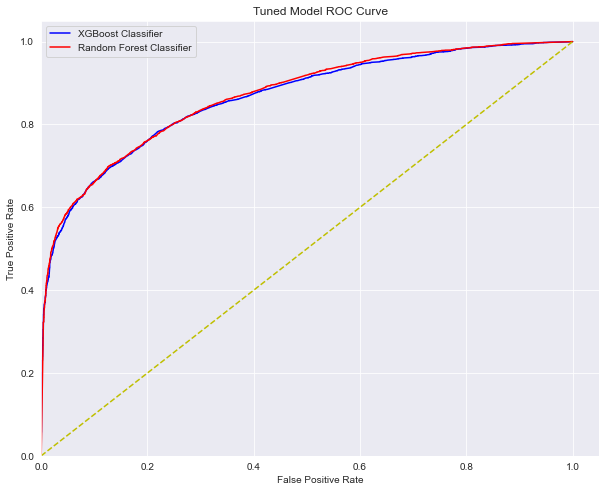

In [66]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

plt.plot(xgb_tpr, xgb_fpr, color = 'b', label = 'XGBoost Classifier')
plt.plot(forest_tpr, forest_fpr, color = 'r', label = 'Random Forest Classifier')
plt.plot([0, 1], [0, 1], color = 'y', linestyle = '--')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Model ROC Curve')
plt.legend()
plt.show()